## Prepare funtions, libraries for report and metrics

In [473]:
from typing import List

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import GradientBoostingRegressor as gbr


def get_rmse(y_test, y_pred):
    return np.sqrt(metrics.mean_squared_error(y_test,y_pred))

def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = get_rmse(true, predicted)
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    print('______')
    return [mae, mse, rmse, r2_square]


def print_evaluate_r_square_mse_mae(X_test, y_test, gbr_y_pred):
    r_squared = gbr.score(X_test, y_test)
    mse = metrics.mean_squared_error(y_test, gbr_y_pred)
    mae = metrics.mean_absolute_error(y_test, gbr_y_pred)
    print(f"R-squared value of GradientBoostingRegressor: {r_squared}")
    print(f"The mean squared error of GradientBoostingRegressor: {mse}")
    print(f"The mean absoluate error of GradientBoostingRegressor: {mae}")
    return [r_squared, mse, mae]


def show_df(
    title: str,
    columns: List[str],
    rows: List[list],
    label_x: str = "Metrics",
    label_y: str = "Value",
):
    width = 0.3
    x = np.arange(len(columns))
    fig, ax = plt.subplots(figsize=(10, 6))
    labels = ["Ogul", "Yury"]
 
    rects1 = ax.bar(x - width/2, rows[0], width, label=labels[0])
    rects1 = ax.bar(x + width/2, rows[1], width, label=labels[1])
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(columns)
    ax.legend(loc='upper left')

## Prepare DataFrame

In [474]:
data = pd.read_csv("Real estate.csv")
data.head(5)

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


In [475]:
y = data.iloc[:,-1]
y.head()

0    37.9
1    42.2
2    47.3
3    54.8
4    43.1
Name: Y house price of unit area, dtype: float64

In [476]:
data.drop(['Y house price of unit area', 'No'], axis=1, inplace=True)
data.head()

,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude
0,2012.917,32.0,84.87882,10,24.98298,121.54024
1,2012.917,19.5,306.59470,9,24.98034,121.53951
2,2013.583,13.3,561.98450,5,24.98746,121.54391
3,2013.500,13.3,561.98450,5,24.98746,121.54391
4,2012.833,5.0,390.56840,5,24.97937,121.54245


In [477]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(data,y,test_size=0.2,random_state=42)

## Check by LinearRegression

In [478]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)

LinearRegression_Yury = print_evaluate(y_test, y_pred)

MAE: 5.305355690074294
MSE: 53.50561912450431
RMSE: 7.314753524521814
R2 Square 0.6810580555095813
______


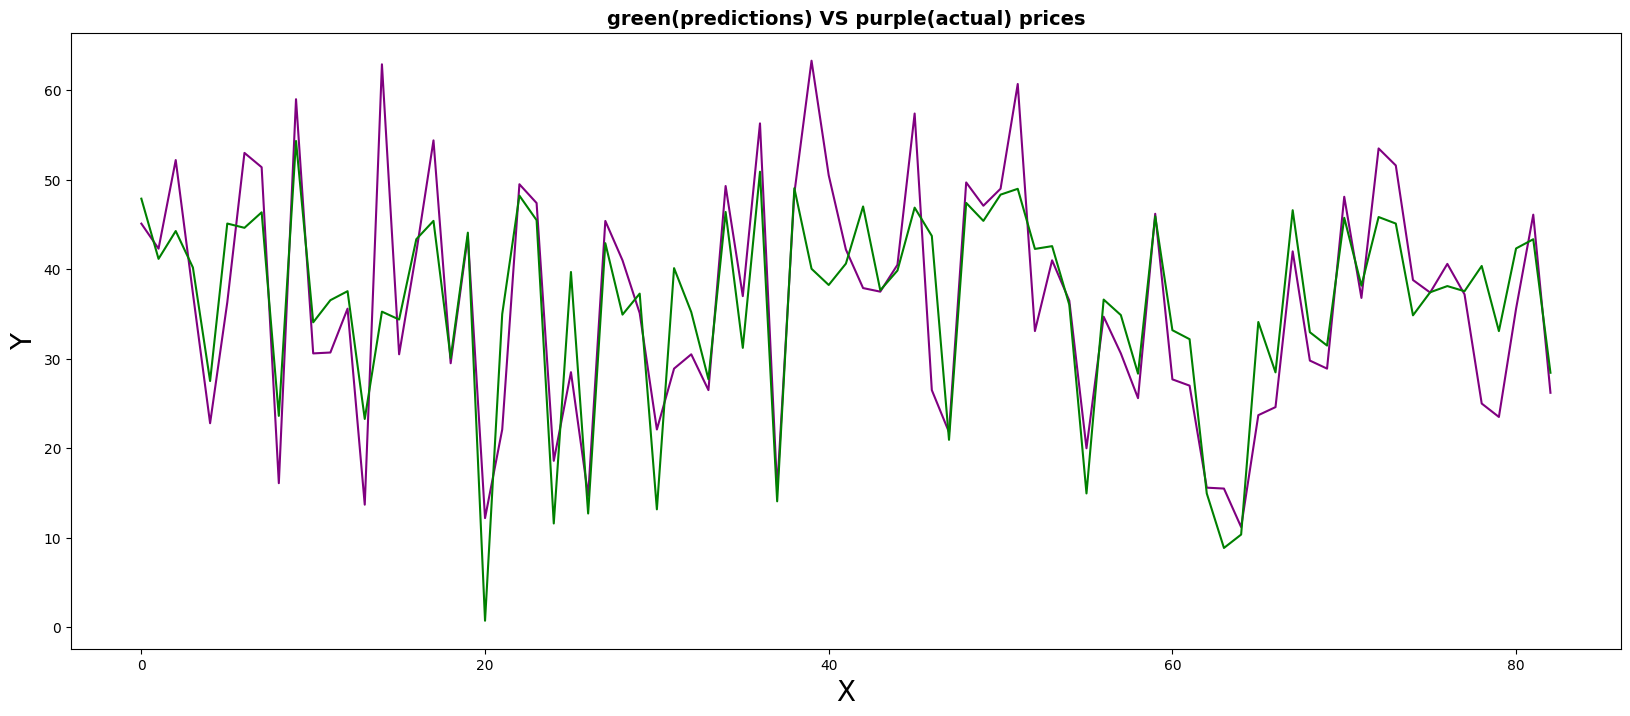

In [479]:
plt.figure(figsize = (20, 8))
plt.plot(y_test.to_numpy(dtype=object)[:100], color = "purple")
plt.plot(y_pred[:100], color = "green")
plt.title("green(predictions) VS purple(actual) prices", fontsize = 14, fontweight = "bold") #updated here
plt.ylabel("Y",fontsize = 20)
plt.xlabel("X",fontsize = 20)

plt.show()

## Check by GradientBoostingRegressor

In [480]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train)
gbr_y_pred = gbr.predict(X_test)

GradientBoostingRegressor_Yury = print_evaluate_r_square_mse_mae(X_test, y_test, gbr_y_pred)


R-squared value of GradientBoostingRegressor: 0.7835372200126698
The mean squared error of GradientBoostingRegressor: 36.31374066881753
The mean absoluate error of GradientBoostingRegressor: 3.9537907877285257


Text(0.5, 1.0, 'The result of GradientBoostingRegressor')

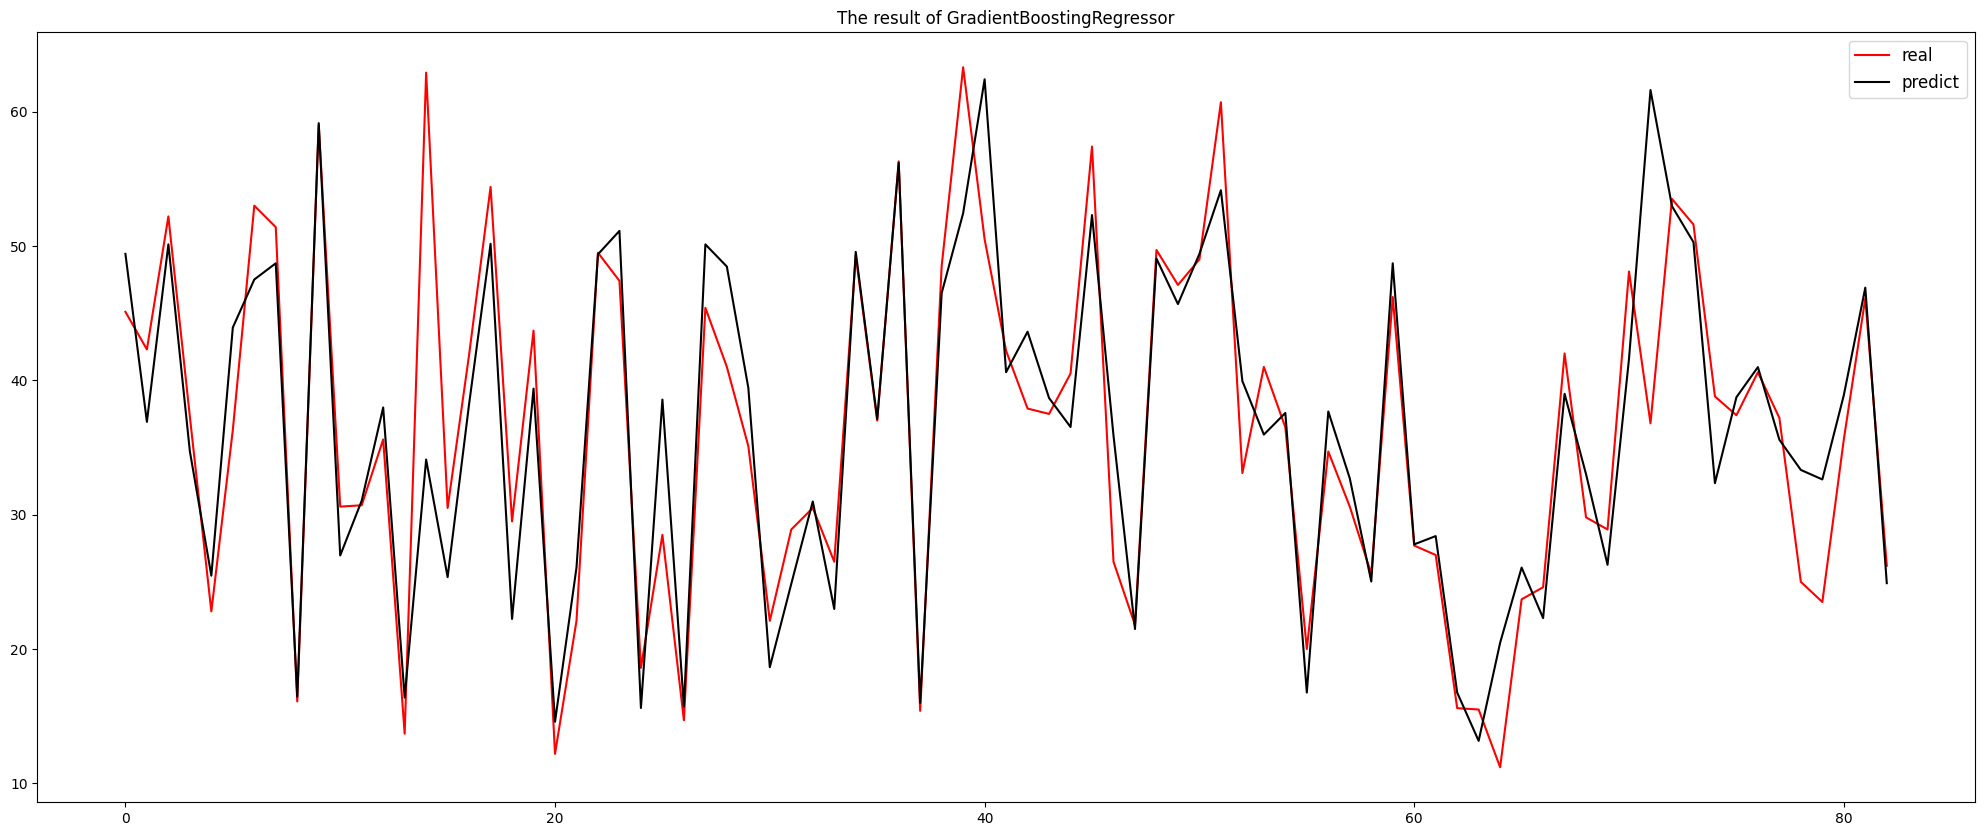

In [481]:
plt.figure(figsize=(25,10))
plt.plot(y_test.to_numpy(dtype=object)[:100],c='red')
plt.plot(gbr_y_pred[:100],c='black')  #predicts
plt.legend(['real','predict'],fontsize="large")
plt.title('The result of GradientBoostingRegressor')

## Check by RandomForestRegressor with scaling

#### Test set

In [482]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(data=scaler.transform(X_train),columns = X_train.columns,index=X_train.index)
X_test = pd.DataFrame(data=scaler.transform(X_test),columns = X_test.columns,index=X_test.index)

In [483]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=500)
rfr.fit(X_train,y_train)

rfr_y_pred = rfr.predict(X_test)

test = print_evaluate_r_square_mse_mae(X_test, y_test, rfr_y_pred)

R-squared value of GradientBoostingRegressor: -0.8030627864653106
The mean squared error of GradientBoostingRegressor: 31.473234003366393
The mean absoluate error of GradientBoostingRegressor: 3.8260402065404304


Text(0.5, 1.0, 'The result of RandomForestRegressor')

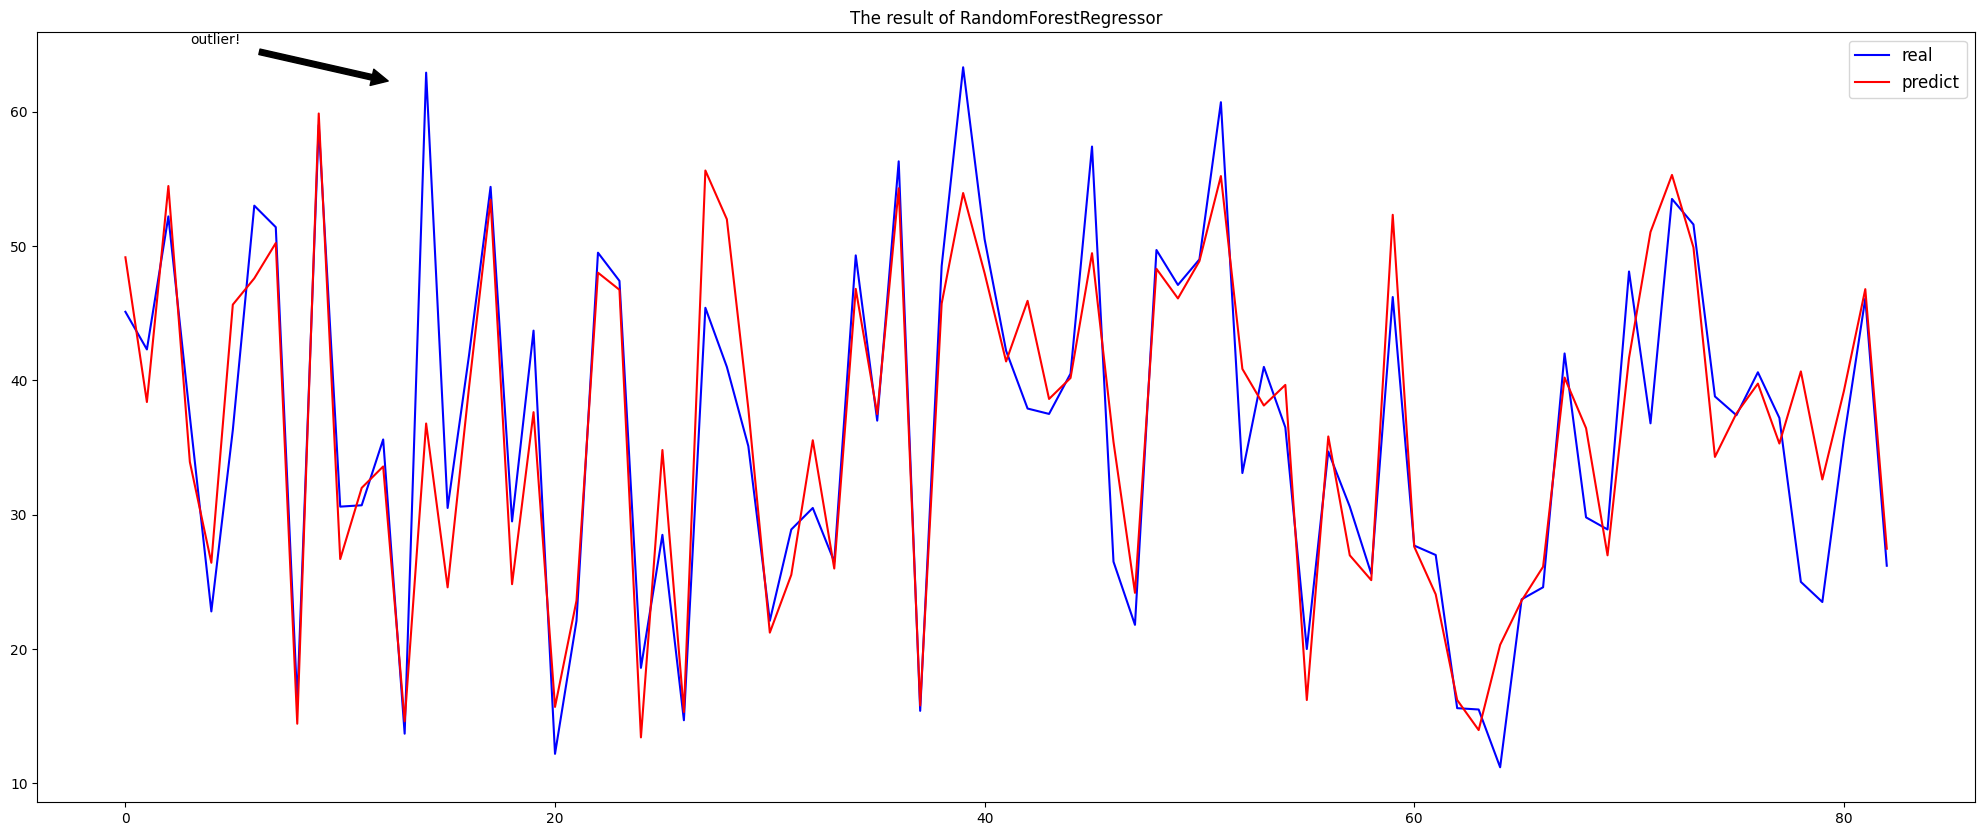

In [484]:
plt.figure(figsize=(25,10))
plt.plot(y_test.to_numpy(dtype=object)[:200],c='blue')
plt.plot(rfr_y_pred[:200],c='red')
plt.annotate(
    # Label and coordinate
    'outlier!',
    xy=(13, 62),
    xytext=(3, 65),
    # Custom arrow
    arrowprops=dict(facecolor='black', shrink=0.1)
)
plt.legend(['real','predict'],fontsize="large")
plt.title('The result of RandomForestRegressor')

#### Train set

In [485]:
from sklearn.ensemble import RandomForestRegressor

rfr_reg = RandomForestRegressor(n_estimators=200)  # maybe parameter tuning
rfr_reg.fit(X_train, y_train)

train_pred = rfr_reg.predict(X_train)


print('Testing set evaluation:\n______')
RandomForestRegressor_Yury_test = print_evaluate(y_test, rfr_y_pred)
print('==*******==')
print('Training set evaluation:\n_____')
RandomForestRegressor_Yury_train = print_evaluate(y_train, train_pred)




Testing set evaluation:
______
MAE: 3.8260402065404304
MSE: 31.473234003366393
RMSE: 5.610101068908331
R2 Square 0.812391023285283
______
==*******==
Training set evaluation:
_____
MAE: 1.917715753129046
MSE: 9.079433807100141
RMSE: 3.0132098843426327
R2 Square 0.9517283770931504
______


Text(0.5, 1.0, 'The result of RandomForestRegressor')

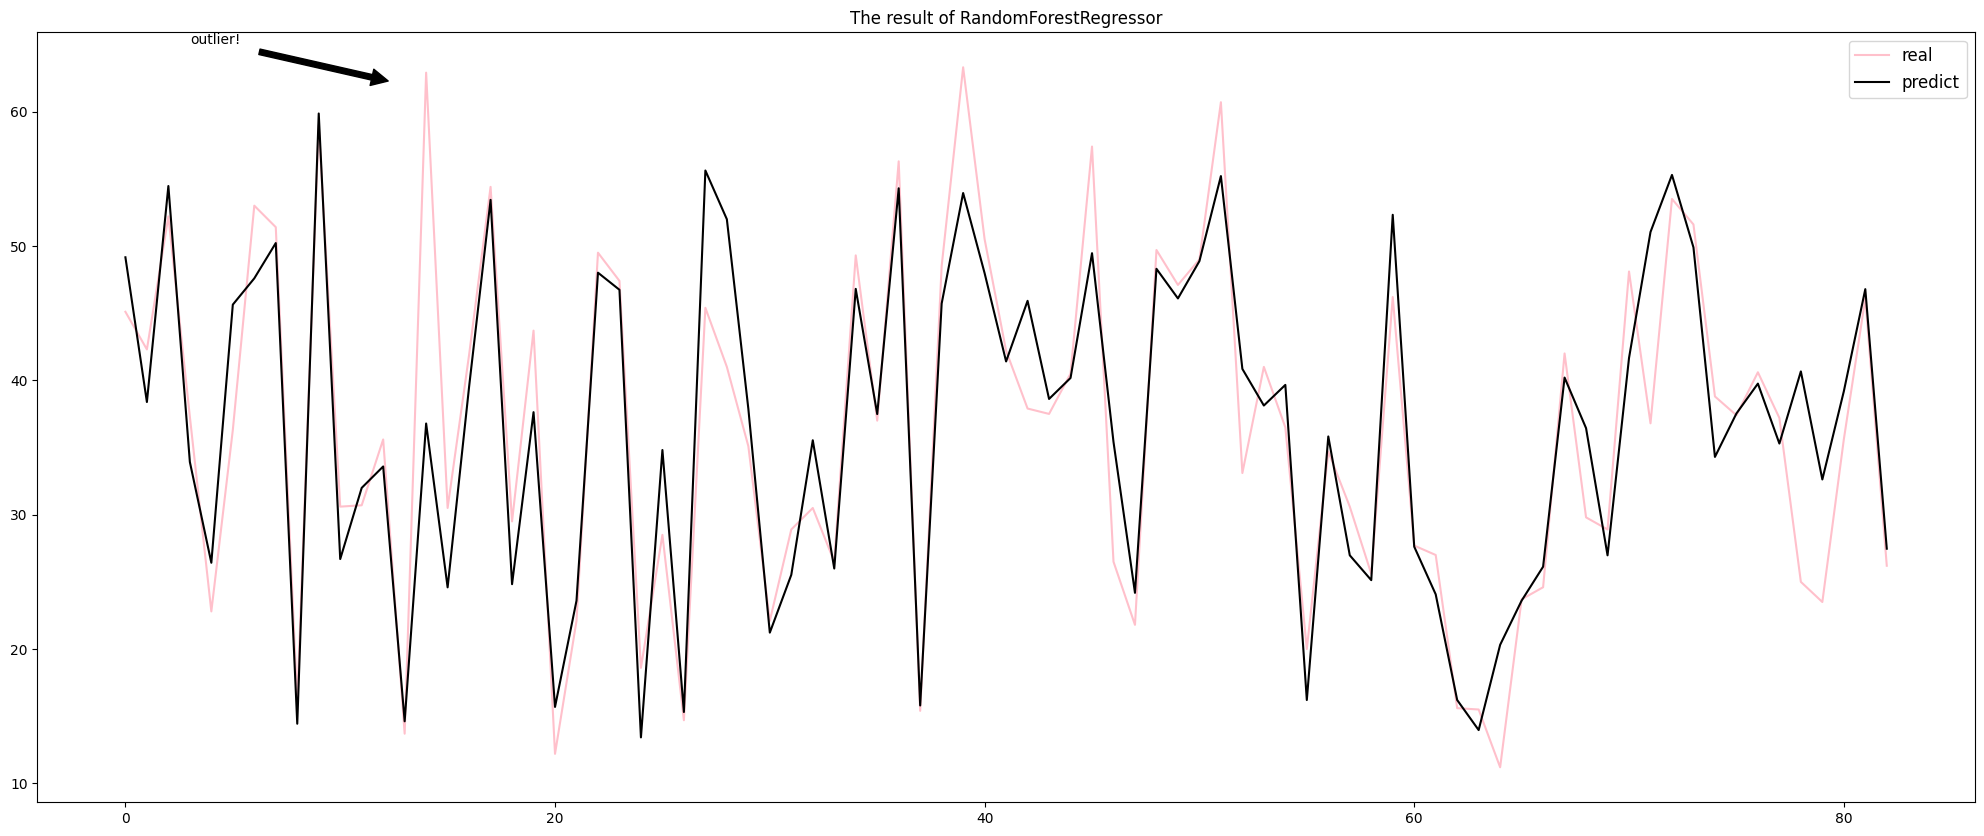

In [486]:
plt.figure(figsize=(25,10))
plt.plot(y_test.to_numpy(dtype=object)[:100],c='pink')
plt.plot(rfr_y_pred[:100],c='black')  #predicts
plt.annotate(
    # Label and coordinate
    'outlier!',
    xy=(13, 62),
    xytext=(3, 65),
    # Custom arrow
    arrowprops=dict(facecolor='black', shrink=0.1)
)
plt.legend(['real','predict'],fontsize="large")
plt.title('The result of RandomForestRegressor')

## Comparison of results before and after optimizations

* best values of metrics
* MAE -> 0.0
* MSE -> 0.0
* RMSE -> should be less 180
* R2 Square -> 1.0

#### LinearRegression

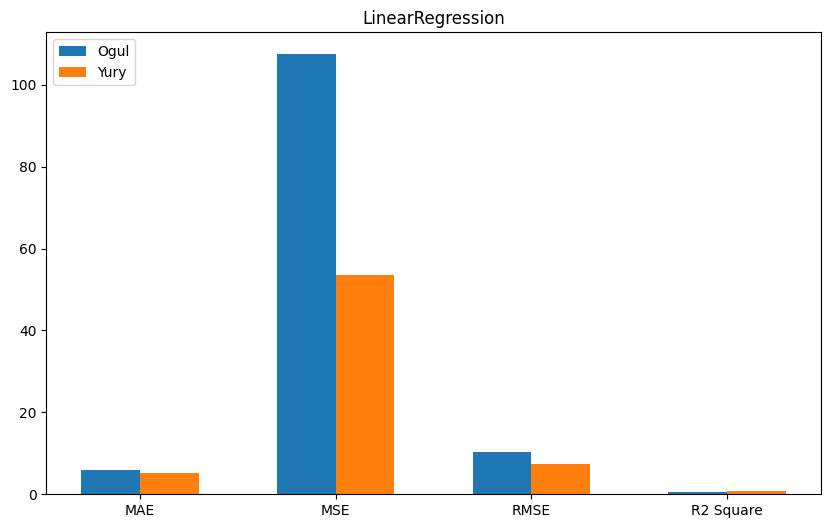

In [487]:
show_df(
    "LinearRegression",
    ["MAE", "MSE", "RMSE", "R2 Square"],
    [
        [5.9812519106284405, 107.45657447745383, 10.36612630047762, 0.5152898373983683], # Ogul homework
        LinearRegression_Yury
    ]
)

#### GradientBoostingRegressor

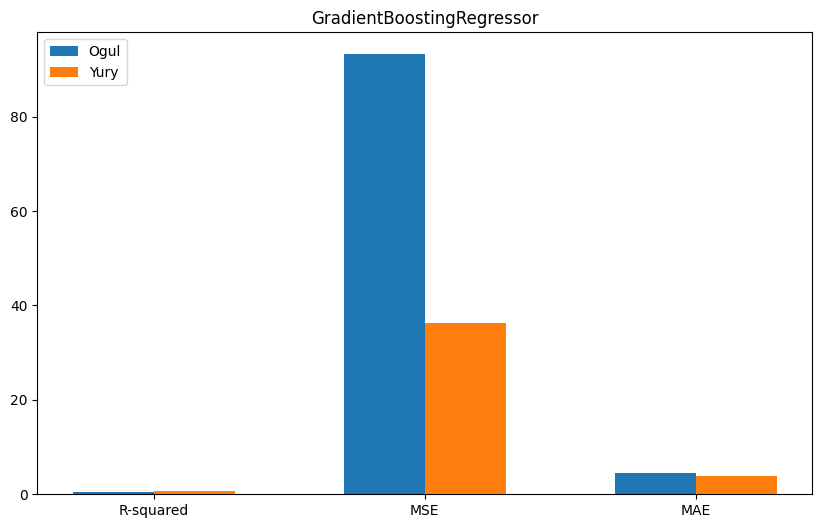

In [488]:
show_df(
    "GradientBoostingRegressor",
    ["R-squared", "MSE", "MAE"],
    [   [0.5796002926773495, 93.19943328141828, 4.52650622749768], # Ogul homework
        GradientBoostingRegressor_Yury
    ]
)

#### RandomForestRegressor - Test set

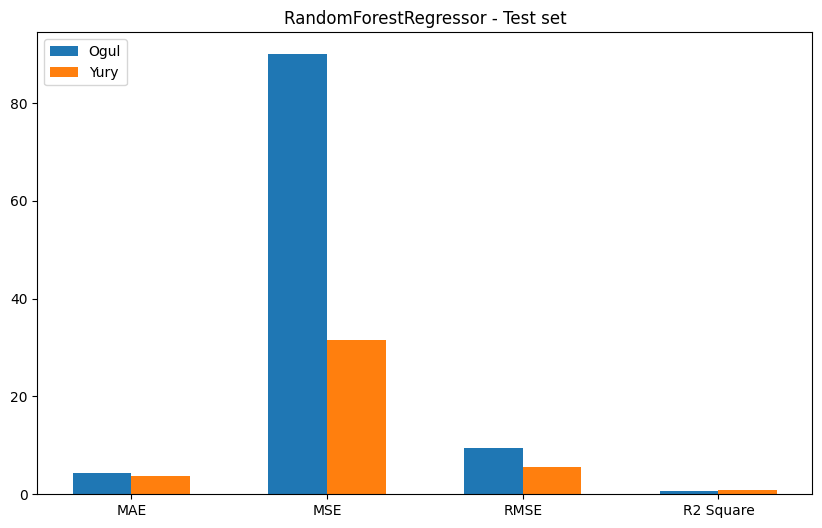

In [489]:
show_df(
    "RandomForestRegressor - Test set",
    ["MAE", "MSE", "RMSE", "R2 Square"],
    [
        [4.25834096385541, 89.96351775144545, 9.48491000228497, 0.5941967112801719], # Ogul homework
        RandomForestRegressor_Yury_test
    ]
)

#### RandomForestRegressor - Train set

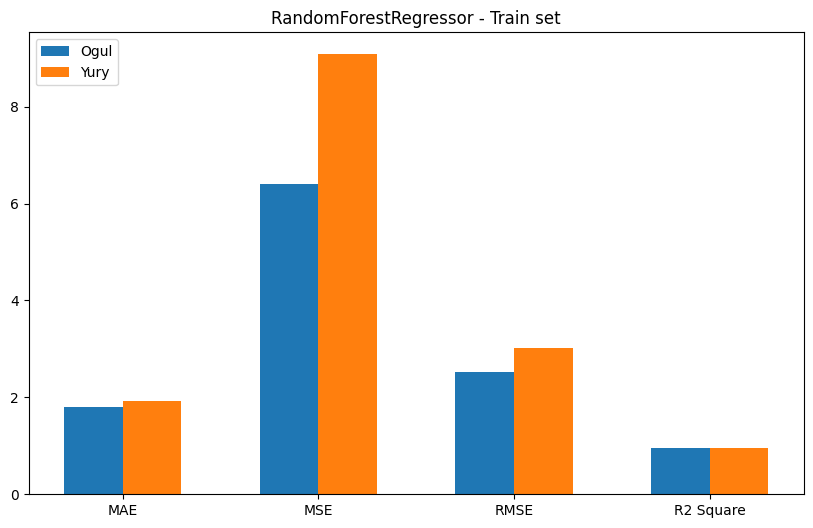

In [490]:
show_df(
    "RandomForestRegressor - Train set",
    ["MAE", "MSE", "RMSE", "R2 Square"],
    [   
        [1.79391661631419, 6.4060702859214365, 2.5310215893827213, 0.9630478911113793], # Ogul homework
        RandomForestRegressor_Yury_train
    ]
)